In [17]:
import tensorflow as tf
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras import optimizers, losses, activations, constraints, regularizers
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
# from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from skimage import exposure, filters
from skimage.morphology import disk, remove_small_objects
from skimage.filters import rank, threshold_isodata

def processImage(image):
    w, h, _ = image.shape
    if np.ptp(image) <= 2:
        image = image*255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    image = image/255.0 - 0.5
    img = np.reshape(image, (-1,3))
    mu, eig = cv2.PCACompute(img, np.empty((0)))
    img = np.dot(img - mu, eig.T)
    S = np.reshape(img, image.shape)
    S = S[:,:,0]
    S = (S-np.min(S))/(np.max(S)-np.min(S))
    r = int((w**2+h**2)**0.5)
    selem = disk(r)//72
    T = rank.equalize(S, selem=selem)
    T = S*T/255
    J = exposure.equalize_adapthist(S, [w//24,h//24],nbins=256, clip_limit=0.01)*255
    Jf = cv2.GaussianBlur(J,(9,9),0)
    Z = Jf - J
    L = threshold_isodata(Z)
    Z = np.array(Z, dtype = np.uint8)
    ret, bw = cv2.threshold(Z, L, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    bwc = remove_small_objects(bw, min_size=(r//24)**2, connectivity=4)
    oddSzw = 2*(w//48)-1
    oddSzh = 2*(h//48)-1
    bwc = cv2.GaussianBlur(bwc,(oddSzw,oddSzh),0)
    bwc = exposure.equalize_adapthist(S*bwc/255, nbins=256)
    img = np.concatenate([np.expand_dims(i, -1) for i in [bwc, S, T]], -1)
    return img

Using TensorFlow backend.


/home/monowar.a/anaconda3/envs/tf-cv2/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/monowar.a/anaconda3/envs/tf-cv2/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


1.0


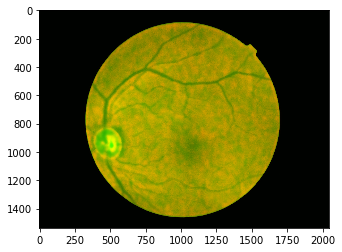

In [2]:
image = cv2.imread("../Aptos2019/train/0/0151781fe50b.png")
# image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = processImage(image)
print(np.ptp(img))
plt.imshow(img)

In [20]:
IMG_SIZE = 512
train_datagen = ImageDataGenerator(
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.25,
        fill_mode='constant', cval=0,
        preprocessing_function=processImage)

train_generator = train_datagen.flow_from_directory(
        '../Aptos2019/train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=12,
        class_mode='categorical', 
        subset='training')
val_generator = train_datagen.flow_from_directory(
        '../Aptos2019/train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=12,
        class_mode='categorical',
        subset='validation')

Found 29094 images belonging to 5 classes.
Found 9694 images belonging to 5 classes.


In [80]:
import os
class_weight = {i:(38788 - len(os.listdir(f'../Aptos2019/train/{i}/')))/38788.0 for i in range(5)}
class_weight

{0: 0.28805300608435597,
 1: 0.9274775703825926,
 2: 0.8378106630916778,
 3: 0.9725172733835207,
 4: 0.974141487057853}

In [22]:
eda_generators = [train_datagen.flow_from_directory(
        f'../Aptos2019/train/{i}/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=3,
        class_mode=None, 
        subset='training') for i in range(5)]

Found 25810 images belonging to 25810 classes.
Found 2443 images belonging to 2443 classes.
Found 5292 images belonging to 5292 classes.
Found 873 images belonging to 873 classes.
Found 708 images belonging to 708 classes.


In [82]:
import numpy as np
x = []
y = []
for i in range(5):
    X = eda_generators[i].__next__()
    x.append(X)
    y.append(np.ones((3))*i)
    
x = np.concatenate(x)
y = np.concatenate(y)
np.ptp(x), np.max(x), np.min(x)

/home/monowar.a/anaconda3/envs/tf-cv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/monowar.a/anaconda3/envs/tf-cv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(1.0, 1.0, 0.0)

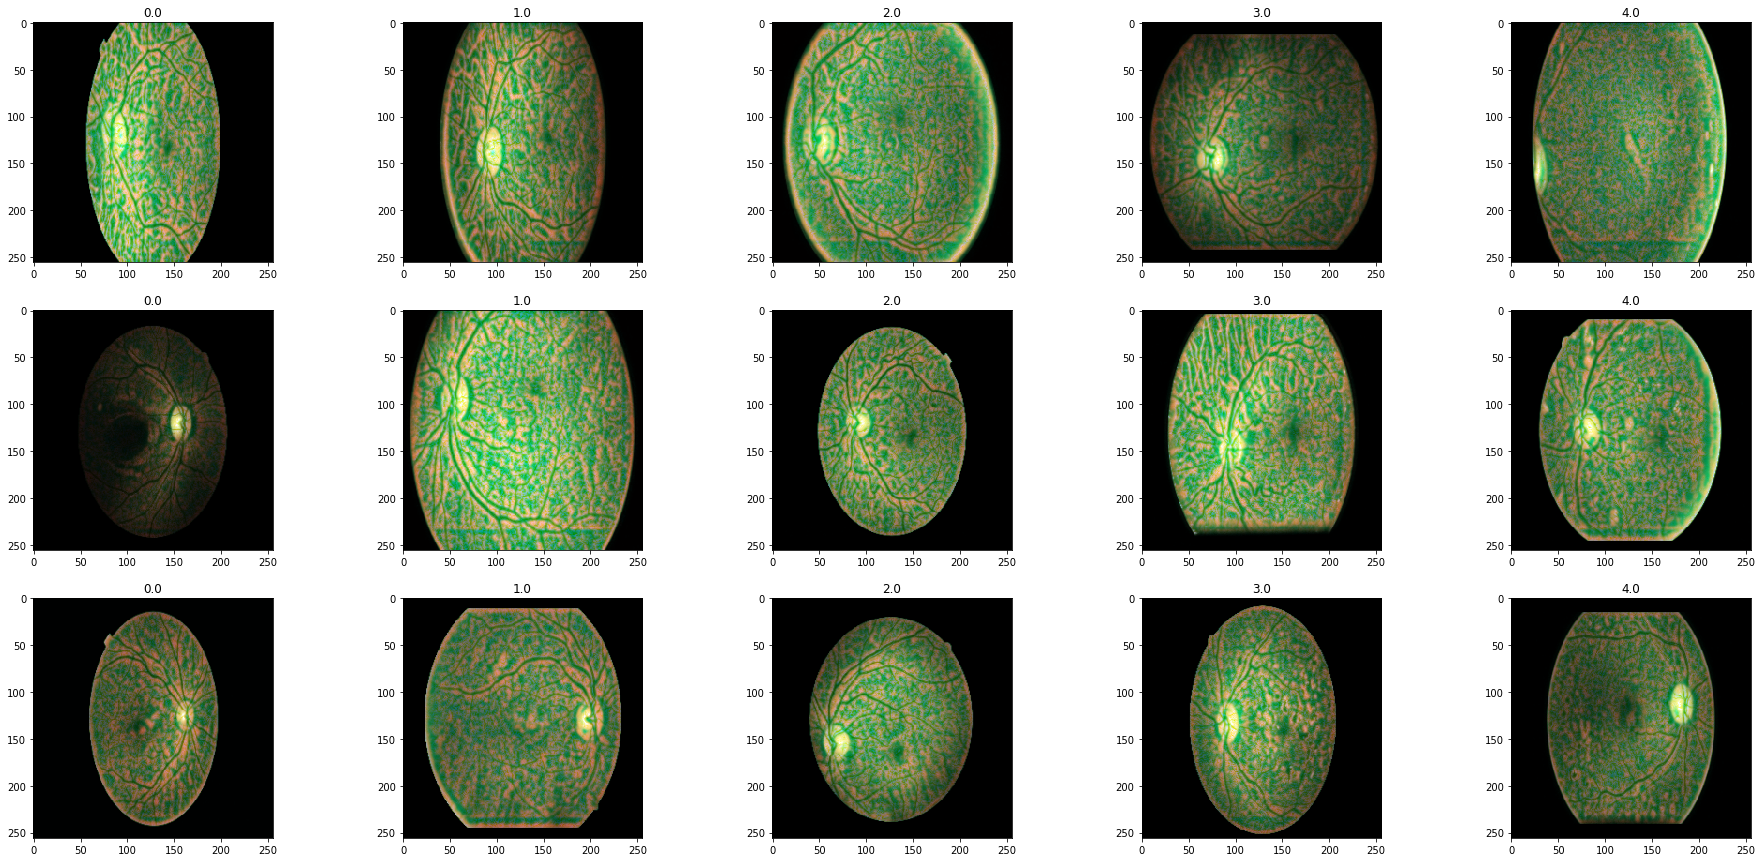

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32,15))
for i in range(5):
    for j in range(3):
        indf = 1 + 5*j + i
        indx = 3*i+j
        img = x[indx,:,:,:]
        ax = plt.subplot(3,5,indf)
        plt.imshow(img)
#         plt.imshow(img[:,:,2], cmap='gray')
        ax.set_title(f'{y[indx]}')

In [14]:
import cv2

In [15]:
cv2.__version__

'4.1.0'

In [15]:
os.listdir('../Aptos2019/train/1/18155_right.jpeg/train')

['18155_right.jpeg']

In [30]:
import os
import os.path
from tqdm import tnrange, tqdm_notebook
from skimage.io import imsave, imread
f = []
root = '../Aptos2019/train/'

for i in range(5):
    f = eda_generators[0].filenames
    for i in tnrange(len(f)):
        fn = os.path.basename(f[i])
        print(fn,f[i])
        img = processImage(imread(f"{root}{i}/"+f[i]))
        imsave(f'train/{i}/{fn}', img)
# for i in tqdm_notebook(range(len(f))):
#     img = processImage(imread(f[i]))
#     p = f[i][t:]
#     imsave(p, img)
    

10003_left.jpeg 10003_left.jpeg/train/10003_left.jpeg
10003_right.jpeg 10003_right.jpeg/train/10003_right.jpeg


FileNotFoundError: [Errno 2] No such file or directory: '../Aptos2019/train/1/10003_right.jpeg/train/10003_right.jpeg'

In [55]:
i = 0
print(f"train\{i}")

train\0


In [ ]:
from zipfile import ZipFile
import pandas as pd
# with ZipFile('../Aptos2019/trainEyePacs.zip') as z:
#     print(z.namelist()[1])
df = pd.read_csv('../Aptos2019/trainLabelsEyePacs.csv')
imageSets = [list(df.groupby('level').get_group(i)['image']) for i in range(5)]

print([len(i) for i in imageSets])
with ZipFile('../Aptos2019/trainEyePacs.zip') as z:
    l = z.namelist()
#     l.sort(key=len)
#     print(l)
    for i in tnrange(len(df)):
        fn = df['image'][i]
        lbl = df['level'][i]
        dest = f"train/{lbl}/{fn}.jpeg"
        src = f"train/{fn}.jpeg"
        try:
            z.extract(src, dest)
        except:
            print(dest)

[25810, 2443, 5292, 873, 708]
